# Visualize networks

This notebook reads both the graph data generated by the co-occurence reading and the network analysis data which calculates the centrality data, and visualizes this per chapter (network representation) and for a whole book (line graph).

## User variables

In [3]:
# path to where the graphs are stored
path = "c:/Frederik/Afstuderen/Results/test16/"

# path where centrality measure rankings are stored
analysispath = "{}analysis/".format(path)
# export path
exportpath = "{}visualization/".format(path)

# how many names to show in name plot
long_names = 20

# how many nodes to show in network plot
lat_names = 100
# set if you want the colors of the nodes to represent nametypes to true
# otherwise the color of the node represent the centrality of the node
nametypeiscolor = True

## Import and open files

In [4]:
%matplotlib inline
import networkx as nx
import os
import re
import matplotlib.pyplot as plt
import numpy as np
import csv
import collections
import forceatlas

if not os.path.exists(exportpath):
    os.makedirs(exportpath)

graphs = collections.defaultdict(lambda:0)
bookgraph = ''
chapterlist = []

for file in os.listdir(path):
    if file.endswith(".gexf"):
        match = re.search(r'Bible_([\w]+)\.gexf', file)
        if match is not None:
            graphs[match.group(1)] = nx.read_gexf(path+file, relabel=True)
            print("Imported {}".format(file))
            
            bookmatch = re.search(r'Bible_([A-Za-z_]+)\.gexf', file)
            chaptermatch = re.search(r'_(\d+)', file)
            
            if bookmatch is not None:
                if bookgraph:
                    print('Using {} as the bookgraph in the filtered book network'.format(bookmatch.group(1)))
                bookgraph = graphs[match.group(1)]
            elif chaptermatch is not None:
                chapterlist.append(match.group(1))

Imported Bible_Judices.gexf
Imported Bible_Judices_01.gexf
Imported Bible_Judices_02.gexf
Imported Bible_Judices_03.gexf
Imported Bible_Judices_04.gexf
Imported Bible_Judices_05.gexf
Imported Bible_Judices_06.gexf
Imported Bible_Judices_07.gexf
Imported Bible_Judices_08.gexf
Imported Bible_Judices_09.gexf
Imported Bible_Judices_10.gexf
Imported Bible_Judices_11.gexf
Imported Bible_Judices_12.gexf
Imported Bible_Judices_13.gexf
Imported Bible_Judices_14.gexf
Imported Bible_Judices_15.gexf
Imported Bible_Judices_16.gexf
Imported Bible_Judices_17.gexf
Imported Bible_Judices_18.gexf
Imported Bible_Judices_19.gexf
Imported Bible_Judices_20.gexf
Imported Bible_Judices_21.gexf


### Import centrality scores

In [5]:
pergraph = collections.defaultdict(lambda: collections.defaultdict(list))
pername = collections.defaultdict(lambda: 0)
centrality_measures = []

for file in os.listdir(analysispath):
    match = re.search(r'(pergraph|pername)_([\w]+)\.csv', file)
    
    if match is not None:
        centrality_measure = match.group(2)
        if centrality_measure not in centrality_measures:
            centrality_measures.append(centrality_measure)
        
        if match.group(1) == 'pergraph':
            with open(analysispath + match.group(0), mode="r") as infile:
                reader = csv.reader(infile)
                for rows in reader:
                    pergraph[centrality_measure][rows[0]].append([rows[1], float(rows[2])])
            print("Imported {}".format(file))

        if match.group(1) == 'pername':
            with open(analysispath + match.group(0), mode="r") as infile:
                reader = csv.reader(infile)
                pername[centrality_measure] = list(reader)
                for a in pername[centrality_measure]:
                    for idx, b in enumerate(a):
                        try:
                            a[idx] = float(b)
                        except ValueError:
                            pass
            print("Imported {}".format(file))

Imported pergraph_eigenvector_centrality.csv
Imported pergraph_katz_centrality.csv
Imported pername_eigenvector_centrality.csv
Imported pername_katz_centrality.csv


## Longitudinal plot

### Create arrays and fill plot

eigenvector_centrality
Saved graph to c:/Frederik/Afstuderen/Results/test16/visualization/long_eigenvector_centrality.png
katz_centrality
Saved graph to c:/Frederik/Afstuderen/Results/test16/visualization/long_katz_centrality.png


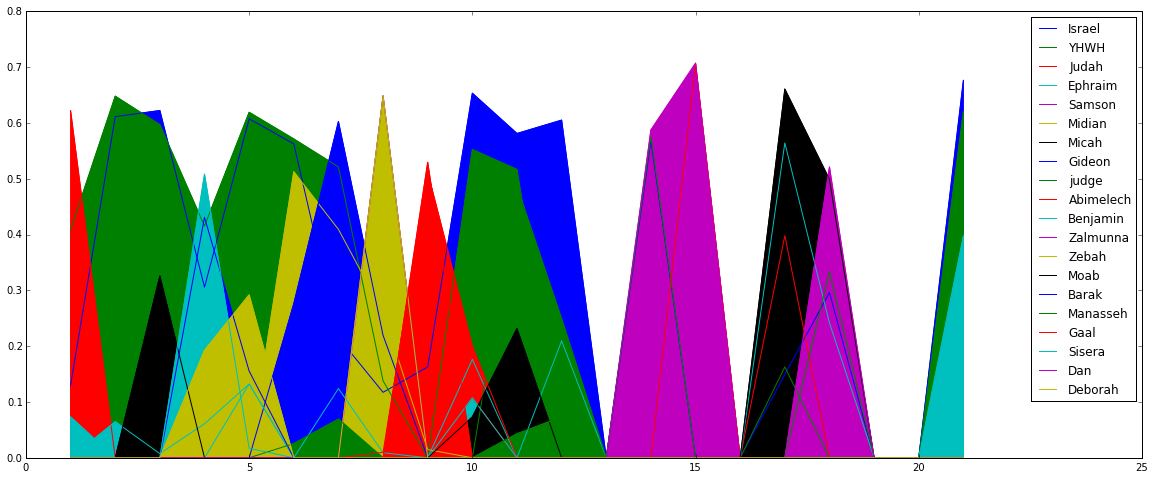

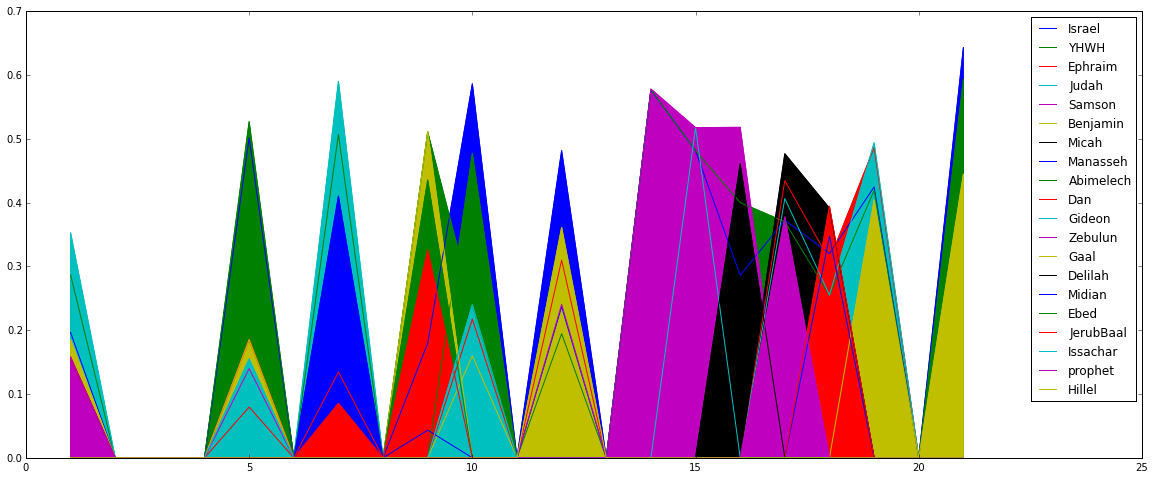

In [7]:
if pername:
    for centrality_measure in centrality_measures:
        print(centrality_measure)

        # create arrays
        a = np.array(pername[centrality_measure])
        a_sort = a[a[:,-1].argsort()]
        a_rev = a_sort[::-1]
        a_num = a_rev[:,1:len(a_rev[0])-1].transpose().astype(np.float)
        a_legend = a_rev[:,0].transpose()
        x = range(1, len(a_rev[0])-1)

        # create fill plot
        plt.figure(figsize=(20, 8)) # This increases resolution
        myplot = plt.plot(x, a_num[:,0:long_names])
        for name in range(long_names):
            y = a_num[:,name]
            linecolor = myplot[name].get_color()
            plt.fill_between(x,y,color=linecolor, label=a_legend[0:long_names])
        plt.legend(myplot, a_legend[0:long_names])
        
        savepath = "{}long_{}.png".format(exportpath, centrality_measure)
        plt.savefig(savepath)
        print("Saved graph to {}".format(savepath))

## Latitudinal plot

In [16]:
def nametype_color(nametype):
    return {
        '': 'k',
        'pers': 'r',
        'gens': 'g',
        'topo': 'b',
    }.get(nametype, 'w')

### Graphs with centrality measures

### Graphs with centrality measures in filtered book network

In [18]:
if chapterlist and bookgraph:
    # get graph and create positions
    bookgraphpos = forceatlas.forceatlas2_layout(bookgraph)

    # set axis limits
    plt.figure(1,figsize=(35,35))
    nx.draw(bookgraph, pos=bookgraphpos)
    bookaxes = (plt.xlim()[0], plt.xlim()[1], plt.ylim()[0], plt.ylim()[1])
    plt.close()

    for centrality_measure in centrality_measures:
        print(centrality_measure)

        for graphname in pergraph[centrality_measure]:
            if graphname not in chapterlist:
                continue

            # get centrality data from network_analysis to show as colors and sizes,
            # and only show the nodes with the highest centrality rating
            colors = []
            sizes = []
            selectednodes = []

            for counter, node in enumerate(pergraph[centrality_measure][graphname]):
                # print nodes with centrality ratings

                if nametypeiscolor:
                    # colors based on nametype
                    colors.append(nametype_color(graphs[graphname].node[node[0]]['nametype']))
                else:
                    colors.append(node[1])
                selectednodes.append(node[0])
                sizes.append(node[1] ** 0.5 * 1200)

                if counter == lat_names-1:
                    break

            thisgraph = bookgraph.subgraph(selectednodes)

            # draw graph
            plt.figure(1,figsize=(35,35))
            # set axis limits
            plt.axis(bookaxes)
        
            cmap=plt.cm.jet
            vmin = min(colors)
            vmax = max(colors)

            nx.draw(thisgraph, pos=bookgraphpos, nodelist=selectednodes,
                    node_color=colors, with_labels=True, node_size=sizes,
                    width=0.2, alpha=0.5, cmap=cmap, vmin=vmin, vmax=vmax)
            
            if not nametypeiscolor:
                sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.normalize(vmin=vmin, vmax=vmax))
                sm._A = []
                plt.colorbar(sm)

            # draw edge labels
            edgelabels = {}
            for a, b in thisgraph.edges():
                edgelabels[(a, b)] = str(thisgraph.get_edge_data(a, b, {"weight":0})["weight"])

            nx.draw_networkx_edge_labels(thisgraph, pos=bookgraphpos, edge_labels=edgelabels)

            # save as png
            savepath = "{}lat_static_{}_{}.png".format(exportpath, centrality_measure, graphname)
            plt.savefig(savepath)
            print("Saved graph to {}".format(savepath))
            plt.close()